
# Introduction

### - This notebook explores a novel convolutional network architechture as discussed in the following research paper to build a classification system for better assistance in diagonosing Acute Lymphoblastic Leukemia in blood cells.
**[Research Paper](http://www.ijcte.org/vol10/1198-H0012.pdf)**


### - To gain access to the dataset, please visit [here](https://homes.di.unimi.it/scotti/all/#download) and to contribute back to the project, [here](https://homes.di.unimi.it/scotti/all/results.php)

* Here, ALL_IDB2 version of the dataset has been used

* This dataset is completely balanced with equal number of samples in both the classes.


### - Data augmentation ensures that data is large enough and model extracts features efficiently without overfitting and therefore we have analysed the following types of data augmentation techniques in this notebook
* Techniques used in the research paper discussing the following parameters:

   1. Grayscaling of image
   2. Horizontal reflection
   3. Vertical reflection
   4. Gaussian Blurring
   5. Histogram Equalization
   6. Rotation
   7. Translation
   8. Shearing
   
Only training data was augmented. The training dataset contains upto 1170 images after augmentation. The test set has 130 images(10% of the whole dataset)   




### - The results of our present analysis is:

| Data Augmentation    | Accuracy   | Precision   | Recall   |  ROC |
|---|---|---|---|--|
| Used in paper   | 91.5%  | 0.96  | 0.85  | 0.98  |




**This result has been recorded for maximum number of epochs that model could be trained for without overfitting**

**The model has then been quantized so as to ease its deployment on edge devices**





### Below is the detailed code implementation of this research paper 

## **Loading requires packages**

In [0]:
!pip install keras_metrics

In [0]:
from pathlib import Path
import glob
import random
import os
import cv2
from numpy.random import seed
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy import ndimage
from skimage import exposure
import skimage
from skimage import io
from skimage import transform as tm
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import tensorflow.keras
from keras.utils import np_utils
from keras.models import Model,Sequential,model_from_json
from keras.layers import Dense,Flatten,Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input,GaussianNoise
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import keras_metrics
import matplotlib.pyplot as plt
from keras.optimizers import Adam,RMSprop,SGD
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from sklearn.metrics import roc_auc_score
from keras import backend as K
%matplotlib inline

Using TensorFlow backend.


In [0]:
print(tensorflow.keras.__version__)
print(tf.__version__)

2.2.5
1.15.0


In [0]:
# for consistemt results across multiple executions
seed(3)
tf.random.set_seed(3)

## **Mount your Google Drive**

 

##### Upload the **ALL-Keras-2019** directory from your cloned repo to the root of your Google Drive. Use the following commands and follow the provided steps to mount your Google Drive.


In [0]:
root_dir = "/content/drive/My Drive/ALL-Keras-2019/"
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: ###

Enter your authorization code:
###
Mounted at /content/gdrive


#### **You will notice the data folder in the Model directory, Model/Data, inside you have Train,Test and Complete.**

#### **You can place all the images inside the *Complete* folder. We will split them into training and test set below**




In [0]:
data_dir = 'Model/Data/Complete'
dataset = Path(root_dir + data_dir)
images= dataset.glob("*.tif")
data = []

for img in images:
  name, ext = os.path.splitext(os.path.basename(img))
  if name[-1]=='1':
    data.append((img,1))
  elif name[-1]=='0':
    data.append((img,0))
    
data_frame = pd.DataFrame(data,columns=['image','label'],index = None)
data_frame = data_frame.sample(frac=1.).reset_index(drop=True)
data_frame.tail()

,image,label
255,gdrive/My Drive/ALL_IDB2/img/Im022_1.tif,1
256,gdrive/My Drive/ALL_IDB2/img/Im257_0.tif,0
257,gdrive/My Drive/ALL_IDB2/img/Im136_0.tif,0
258,gdrive/My Drive/ALL_IDB2/img/Im255_0.tif,0
259,gdrive/My Drive/ALL_IDB2/img/Im153_0.tif,0


In [0]:
#  Splitting training and test data; we will not be augmenting test data
train = pd.DataFrame()
test = pd.DataFrame()

train = data_frame[:130]
test = data_frame[130:]

## **Data Exploration and Augmentation as presented in the paper**


### 8 augmentation techniques have been used here
1. Grayscaling of image
2. Horizontal reflection 
3. Vertical reflection
4. Gaussian Blurring 
5. Histogram Equalization
6. Rotation
7. Translation
8. Shearing

In [0]:
# histogram equalization function
def hist(img):
  img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
  img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
  hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
  return hist_equalization_result
 

In [0]:
# function to perform rotation on an image
def rotation(img):
  rows,cols = img.shape[0],img.shape[1]
  randDeg = random.randint(-180, 180)
  matrix = cv2.getRotationMatrix2D((cols/2, rows/2), randDeg, 0.70)
  rotated = cv2.warpAffine(img, matrix, (rows, cols), borderMode=cv2.BORDER_CONSTANT,
                                     borderValue=(144, 159, 162))
  return rotated     

In [0]:
# function to perform shearing of an image
def shear(img):
  # Create Afine transform
  afine_tf = tm.AffineTransform(shear=0.5)
  # Apply transform to image data
  modified = tm.warp(img, inverse_map=afine_tf)
  return modified

In [0]:
def aug_method(dataframe,dim,method):
  if method == 'paper':
    n = len(dataframe)
    data = np.zeros((n*9,dim,dim,3),dtype = np.float32)
    labels = np.zeros((n*9,2),dtype = np.float32)
    count = 0

    for j in range(0,n):
      img_name = dataframe.iloc[j]['image']
      label = dataframe.iloc[j]['label']

      encoded_label = np_utils.to_categorical(label, num_classes=2)

      img = cv2.imread(str(img_name))
      img = cv2.resize(img, (dim,dim))

      if img.shape[2]==1:
        img = np.dstack([img, img, img])

      orig_img = img.astype(np.float32)/255.
      data[count] = orig_img
      labels[count] = encoded_label
      
      aug_img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      aug_img2 = cv2.flip(img, 0) 
      aug_img3 = cv2.flip(img,1)
      aug_img4 = ndimage.gaussian_filter(img, sigma= 5.11)
      aug_img5 = hist(img)
      aug_img6 = rotation(img)
      aug_img7 = cv2.warpAffine(img, np.float32([[1, 0, 84], [0, 1, 56]]), (img.shape[0], img.shape[1]),
                                  borderMode=cv2.BORDER_CONSTANT, borderValue=(144, 159, 162))
      aug_img8 = shear(img)
      aug_img1 = np.dstack([aug_img1, aug_img1, aug_img1])


      aug_img1 = aug_img1.astype(np.float32)/255.                 
      aug_img2 = aug_img2.astype(np.float32)/255.
      aug_img3 = aug_img3.astype(np.float32)/255. 
      aug_img4 = aug_img4.astype(np.float32)/255.
      aug_img5 = aug_img5.astype(np.float32)/255.
      aug_img6 = aug_img6.astype(np.float32)/255.
      aug_img7 = aug_img7.astype(np.float32)/255.
      aug_img8 = aug_img8.astype(np.float32)/255.

      data[count+1] = aug_img1
      labels[count+1] = encoded_label
      data[count+2] = aug_img2
      labels[count+2] = encoded_label
      data[count+3] = aug_img3
      labels[count+3] = encoded_label
      data[count+4] = aug_img4
      labels[count+4] = encoded_label
      data[count+5] = aug_img5
      labels[count+5] = encoded_label
      data[count+6] = aug_img5
      labels[count+6] = encoded_label
      data[count+7] = aug_img5
      labels[count+7] = encoded_label
      data[count+8] = aug_img5
      labels[count+8] = encoded_label

      count +=9
      
  elif method == 'keras':
    n = len(dataframe)
    data = np.zeros((n,dim,dim,3),dtype = np.float32)
    labels = np.zeros((n,2),dtype = np.float32)
    count = 0
    
    for j in range(0,n):    
      img_name = dataframe.iloc[j]['image']
      label = dataframe.iloc[j]['label']
      
      encoded_label = np_utils.to_categorical(label, num_classes=2)
            
      img = cv2.imread(str(img_name))
      img = cv2.resize(img, (dim,dim))
      
      if img.shape[2]==1:   
        img = np.dstack([img, img, img])
                                   
      orig_img = img.astype(np.float32)/255.
                        
      data[count] = orig_img
      labels[count] = encoded_label
    
      count +=1      
  return data,labels                  

In [0]:
data_train, labels_train = aug_method(train,dim=100,method='paper')

In [0]:
def test_prep(dataframe,dim):    
  n = len(dataframe)
  data = np.zeros((n,dim,dim,3),dtype = np.float32)
  labels = np.zeros((n,2),dtype = np.float32)
  count = 0

  for j in range(0,n):
    img_name = dataframe.iloc[j]['image']
    label = dataframe.iloc[j]['label']

    encoded_label = np_utils.to_categorical(label, num_classes=2)

    img = cv2.imread(str(img_name))
    img = cv2.resize(img, (dim,dim))

    if img.shape[2]==1:
      img = np.dstack([img, img, img])

    orig_img = img.astype(np.float32)/255.

    data[count] = orig_img
    labels[count] = encoded_label
    count+=1
  return data, labels

In [0]:
data_test,labels_test = test_prep(test,dim=100)

## **Visualizing dataset images**

In [0]:
y = np.argmax(labels_train, axis=-1)

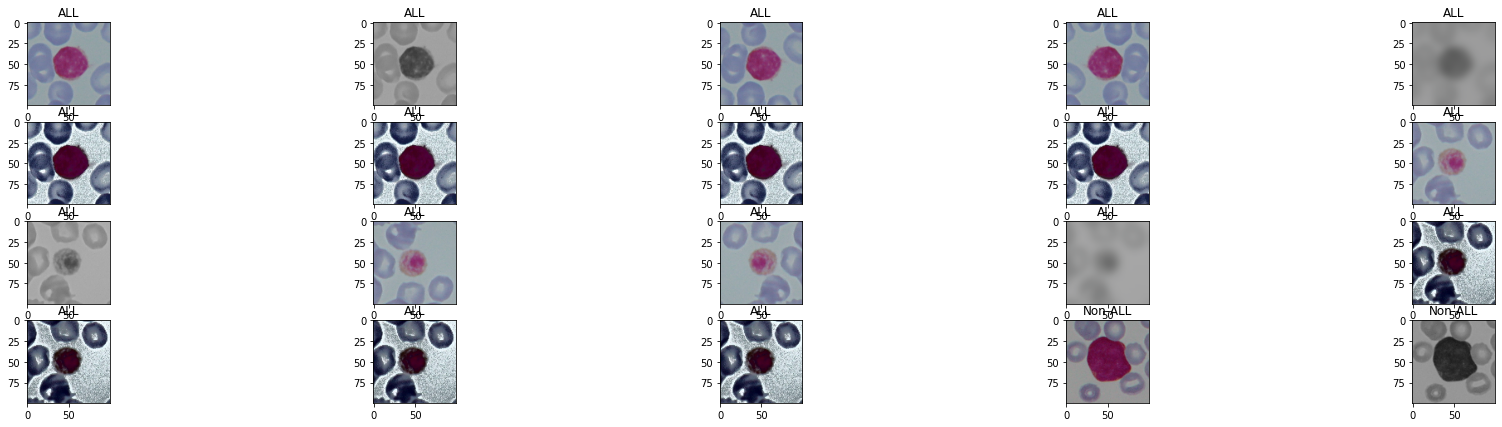

In [0]:
f, ax = plt.subplots(4,5, figsize=(30,7))
for i in range(0,20):
    ax[i//5, i%5].imshow(data_train[i])
    if y[i]==1:
        ax[i//5, i%5].set_title("Non-ALL")
    else:
        ax[i//5, i%5].set_title("ALL")

### **Splitting into training and test set**

In [0]:
X_train, X_test, y_train, y_test = data_train,data_test,labels_train,labels_test

In [0]:
print("Shape of training data",X_train.shape)
print("Shape of testing data",X_test.shape)
print("Shape of training labels",y_train.shape)
print("Shape of testing labels",y_test.shape)

Shape of training data (1170, 100, 100, 3)
Shape of testing data (130, 100, 100, 3)
Shape of training labels (1170, 2)
Shape of testing labels (130, 2)




###**The following model was used in the paper**
Additionaly three dropout layers with different dropout rates have been used to reduce overfitting

In [0]:
model = Sequential()
model.add(Conv2D(16,(5,5),padding='valid',input_shape = X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.4))

model.add(Conv2D(32,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.6))

model.add(Conv2D(64,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.8))

model.add(Flatten())
model.add(Dense(2,activation = 'softmax'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        1216      
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        12832     
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)       

### **Model compilation and fitting**



In [0]:
batch_size = 100
epochs= 300
optimizer = keras.optimizers.rmsprop(lr = 0.0001, decay = 1e-6)
model.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics = ['accuracy',keras_metrics.precision(), keras_metrics.recall()])

In [0]:
history = model.fit(X_train,y_train,steps_per_epoch = int(len(X_train)/batch_size),epochs=epochs)
history








Epoch 1/300
11/11 [==============================] - 9s 782ms/step - loss: 0.7212 - acc: 0.5250 - precision: 0.5309 - recall: 0.5528
Epoch 2/300
11/11 [==============================] - 2s 146ms/step - loss: 0.6871 - acc: 0.5487 - precision: 0.5524 - recall: 0.5862
Epoch 3/300
11/11 [==============================] - 2s 146ms/step - loss: 0.6725 - acc: 0.5750 - precision: 0.5770 - recall: 0.6102
Epoch 4/300
11/11 [==============================] - 2s 145ms/step - loss: 0.6550 - acc: 0.6093 - precision: 0.6083 - recall: 0.6472
Epoch 5/300
11/11 [==============================] - 2s 145ms/step - loss: 0.6357 - acc: 0.6290 - precision: 0.6314 - recall: 0.6466
Epoch 6/300
11/11 [==============================] - 2s 145ms/step - loss: 0.6166 - acc: 0.6514 - precision: 0.6556 - recall: 0.6601
Epoch 7/300
11/11 [==============================] - 2s 145ms/step - loss: 0.5966 - acc: 0.6731 - precision: 0.6867 - recall: 0.6549
Epoch 8/300
11/11 [==============================] - 2s 145ms/

In [0]:
score = model.evaluate(X_test,y_test,verbose=0)
score

[0.185416333629893, 0.9153846153846154, 0.9649122790089258, 0.8593749986572267]

In [0]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred)

0.9857954545454546

**Result for 300 epochs**

**1.Accuracy -91.5%**

**2.Precision -0.96**

**3.Recall -0.85**

**4. AUC score -0.98**


The model stops learning after 300 epochs



### **Visualizing accuracy and loss**


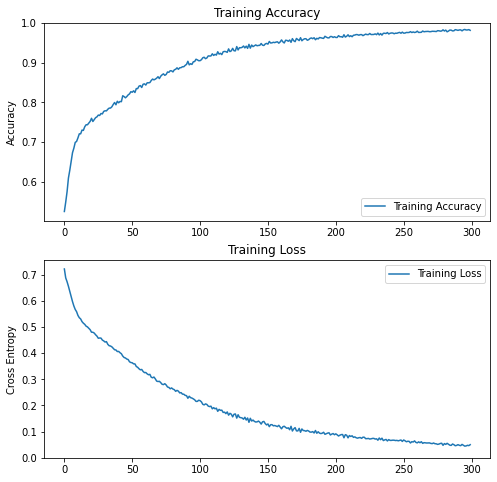

In [0]:
acc = history.history['acc']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training Loss')
plt.show()

### Saving model into ".json" format

In [0]:
with open("model.json", "w") as file:
    file.write(model.to_json())
model.save_weights("weights.h5")

### Turning Keras model into Tensorflow since Movidius NCS compiles Tensorflow or Caffe models only

In [0]:
model_file = "model.json"
weights_file = "weights.h5"

with open(model_file, "r") as file:
    config = file.read()
K.set_learning_phase(0)
model = model_from_json(config)
model.load_weights(weights_file)

saver = tf.train.Saver()
sess = K.get_session()
saver.save(sess, "./TF_Model/tf_model")

fw = tf.summary.FileWriter('logs', sess.graph)
fw.close()

In [0]:
keras.models.save_model(model,weights_file)

### Converting the model into tensorflow lite so that it can run on embedded systems 

In [0]:
converter = tf.lite.TocoConverter.from_keras_model_file(weights_file)
tflite_model = converter.convert()

Instructions for updating:
Use `lite.TFLiteConverter.from_keras_model_file` instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


In [0]:
open("weights.tflite","wb").write(tflite_model)

429344

In [0]:
tflite_models_dir = Path("weights.tflite")

In [0]:
tflite_models_dir.write_bytes(tflite_model)

429344

In [0]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_models_dir))
interpreter.allocate_tensors()

### Converting the model into 8 bit quantised tensorflow lite version

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.post_training_quantize = True

In [0]:
tflite_quant_model = converter.convert()

In [0]:
open("quant_weights.tflite","wb").write(tflite_quant_model)

109448

In [0]:
quant_tflite_models_dir = Path("quant_weights.tflite")

In [0]:
quant_tflite_models_dir.write_bytes(tflite_quant_model)

109448

We can see that the quantised version consumes approximately 1/4th of the memory consumed by non-quantised version

In [0]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_models_dir))
interpreter_quant.allocate_tensors()

In [0]:
#To download the files:
#files.download('weights.h5')
#files.download('weights.tflite')
#files.download('quant_weights.tflite')



### The following two code snippets are to evaluate the tensorflow lite non-quantised and quantised versions.

In [0]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
# change the following line to feed into your own data.
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
#input_data = np.array(X_test)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[9.995455e-01 4.544313e-04]]


In [0]:
# Get input and output tensors.
input_details = interpreter_quant.get_input_details()
output_details = interpreter_quant.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
# change the following line to feed into your own data.
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
#input_data = np.array(X_test[0])
interpreter_quant.set_tensor(input_details[0]['index'], input_data)

interpreter_quant.invoke()
output_data = interpreter_quant.get_tensor(output_details[0]['index'])
print(output_data)

[[9.9987125e-01 1.2867367e-04]]
